# Linear Discriminant Analysis

This notebook aims to try to improve the performance of a random forest after projecting the data into a new space via lda. Classification using the lda model has also been tried but with poor results.

More interesting work concerns the visualisation of the original dataset, the projected dataset via lda and the investigation of the characteristics of well-divided data and conflict zones.

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

seed=42

In [2]:
df = pd.read_pickle("data/job_table_preproc.pkl")

labels = df["job_state"]
df = df.drop(["job_state"], axis=1)
data = df

df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
0,737567,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000.0,1,4,0
1,737567,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000.0,1,4,0
2,737567,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000.0,1,4,0
3,737567,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000.0,1,256,1
4,737567,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000.0,1,4,0


## Visualization of original dataset and Inspection of characteristics

In [25]:
# Plotting of dataset points
def show_space(data, labels, n_comp, x_coord_conflict_area=[0,0], y_coord_conflict_area=[0,0], x_coord_good=[0,0], y_coord_good=[0,0]):
    tsne = TSNE(n_components=n_comp)    
    low_dim_data = tsne.fit_transform(data)
    tsne_df = pd.DataFrame(low_dim_data)
    if n_comp == 2:
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=labels)
        ax.set_yticks(np.arange(-120,120,5))
        ax.set_xticks(np.arange(-120,120,5))
        # plt.axvspan(-40, -30, color='red', alpha=0.5)
        # plt.ayvspan(25, 40, color='red', alpha=0.5)
        x_slice = abs(x_coord_conflict_area[1] - x_coord_conflict_area[0])
        y_slice = abs(y_coord_conflict_area[1] - y_coord_conflict_area[0])
        ax.add_patch(matplotlib.patches.Rectangle((x_coord_conflict_area[0], y_coord_conflict_area[0]), x_slice, y_slice, linewidth=2, edgecolor='red', facecolor='none'))
        x_slice = abs(x_coord_good[1] - x_coord_good[0])
        y_slice = abs(y_coord_good[1] - y_coord_good[0])
        ax.add_patch(matplotlib.patches.Rectangle((x_coord_good[0], y_coord_good[0]), x_slice, y_slice, linewidth=2, edgecolor='green', facecolor='none'))
        plt.xticks(rotation = "vertical")
        plt.grid()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax = fig.add_subplot(111, projection = '3d')
        x = tsne_df[0]
        y = tsne_df[1]
        z = tsne_df[2]
        label = np.where(labels == "COMPLETED", "green", labels)
        label = np.where(label == "FAILED", "red", label)
        label = np.where(label == "TIMEOUT", "orange", label)
        label = np.where(label == "OUT_OF_MEMORY", "blue", label)
        ax.scatter(x, y, z, c=label)
        plt.legend(labels)
        plt.grid()
        plt.show()
    return tsne_df

Selection of a conflict area (red rect) and a well divisible one (green)

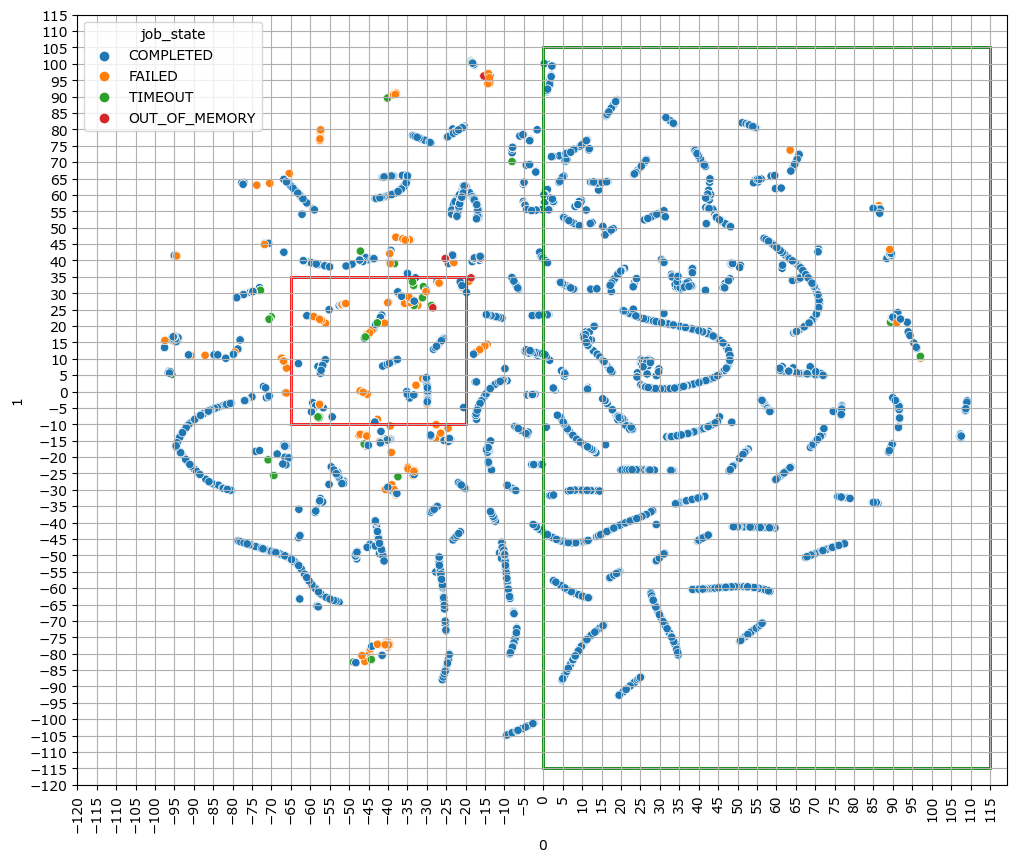

In [9]:
x_coord_conflict_area = [-65, -20]
y_coord_conflict_area = [-10, 35]

x_coord_good = [0, 115]
y_coord_good = [-115, 105]

tsne_df_original = show_space(df[0:10000], labels[0:10000], 2, x_coord_conflict_area, y_coord_conflict_area, x_coord_good, y_coord_good)

In [10]:
tsne_df_original = pd.concat([tsne_df_original[0:10000], labels[0:10000]], axis=1)

For both rects we take only completed jobs, in order to be comparable and to find some substantial difference which could be corrected when someone give a job to slurm.
Is there any constraint I can force to make the completed jobs more similar? Is it possible that some jobs are close to failed because an uninformed user only sets a few parameters? Maybe by putting in a few more simple pieces of information these jobs would be classified correctly.

Taking only completed jobs for the two areas

In [11]:
completed_index = list(tsne_df_original[tsne_df_original['job_state'] == "COMPLETED"].index)
completed_index_conflict_area = [idx for idx in completed_index if (tsne_df_original.iloc[idx][0] > x_coord_conflict_area[0] and tsne_df_original.iloc[idx][0] < x_coord_conflict_area[1]) and (tsne_df_original.iloc[idx][1] > y_coord_conflict_area[0] and tsne_df_original.iloc[idx][1] < y_coord_conflict_area[1])]
completed_index_good_values = [idx for idx in completed_index if (tsne_df_original.iloc[idx][0] > x_coord_good[0] and tsne_df_original.iloc[idx][0] < x_coord_good[1]) and (tsne_df_original.iloc[idx][1] > y_coord_good[0] and tsne_df_original.iloc[idx][1] < y_coord_good[1])]

In [15]:
# good values
df_good = df.iloc[completed_index_good_values]
display(df_good)

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
0,737567,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000.0,1,4,0
1,737567,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000.0,1,4,0
2,737567,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000.0,1,4,0
4,737567,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000.0,1,4,0
10,737567,32171,25200,77949,62883,3,88349,4,10,4,1,4,246000.0,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,737573,32171,25200,77949,60547,3,135534,4,10,128,1,128,246000.0,1,128,0
9992,737573,32171,25200,77949,60593,3,128640,4,10,128,1,128,246000.0,1,128,0
9995,737573,32171,25200,77949,60916,3,115195,4,10,128,1,128,246000.0,1,128,0
9996,737573,32171,25200,77949,60548,3,135524,4,10,128,1,128,246000.0,1,128,0


In [ ]:
# completed jobs inside conflict area
df_conflict = df.iloc[completed_index_conflict_area]
display(df_conflict)

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
12,737567,28803,25200,77303,6816,3,322524,4,30,1,2,2,3800.0,2,2,8
18,737567,25843,25200,61231,11769,3,81357,4,30,32,16,512,920.0,4,512,16
23,737567,28546,25200,29653,54664,3,92913,4,60,32,4,128,237.5,1,128,4
37,737567,28579,25200,77575,56407,3,92873,4,480,1,32,32,230000.0,1,32,2
45,737567,26730,25200,77723,33264,3,329565,1,60,4,4,16,128.0,1,16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9914,737573,32330,25200,43932,41961,3,188320,4,10,1,32,32,60800.0,1,32,0
9915,737573,29283,25200,29953,4424,1,317732,4,480,1,1,1,10.0,1,1,1
9916,737573,32330,25200,43932,41528,3,188641,4,10,1,32,32,60800.0,1,32,0
9919,737573,30924,25200,67730,27413,3,329375,4,1390,1,8,8,7100.0,1,8,0


Properties of the two datasets

In [23]:
display(df_good.describe())
print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
display(df_conflict.describe())

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
count,4986.000000,4986.000000,4986.0,4986.000000,4986.000000,4986.0,4986.000000,4986.0,4986.000000,4986.000000,4986.000000,4986.000000,4.986000e+03,4986.000000,4986.000000,4986.000000
mean,737567.762736,32102.318492,25200.0,77152.835740,63979.623345,3.0,100364.855796,4.0,21.422182,28.635580,2.258524,36.112515,2.585012e+05,1.060168,36.112515,0.219615
std,0.914863,565.227228,0.0,5624.250795,5318.928065,0.0,24387.150927,0.0,98.605812,41.866222,27.536017,80.597645,1.549235e+05,0.666124,80.597645,2.147449
min,737567.000000,25513.000000,25200.0,74.000000,3949.000000,3.0,80279.000000,4.0,10.000000,1.000000,1.000000,1.000000,3.040000e+04,1.000000,1.000000,0.000000
25%,737567.000000,32171.000000,25200.0,77949.000000,63085.250000,3.0,87451.500000,4.0,10.000000,4.000000,1.000000,4.000000,2.460000e+05,1.000000,4.000000,0.000000
50%,737568.000000,32171.000000,25200.0,77949.000000,64393.500000,3.0,92983.500000,4.0,10.000000,4.000000,1.000000,4.000000,2.460000e+05,1.000000,4.000000,0.000000
75%,737568.000000,32171.000000,25200.0,77949.000000,66038.750000,3.0,106447.000000,4.0,10.000000,32.000000,1.000000,32.000000,2.460000e+05,1.000000,32.000000,0.000000
max,737573.000000,32332.000000,25200.0,77949.000000,80942.000000,3.0,326907.000000,4.0,1440.000000,128.000000,1024.000000,1152.000000,3.936000e+06,16.000000,1152.000000,64.000000


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
count,398.000000,398.000000,398.0,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.00000,398.000000,398.000000
mean,737567.987437,29510.381910,25200.0,53825.160804,42518.384422,2.927136,207244.371859,3.874372,250.688442,7.256281,15.005025,97.603015,64611.030151,2.21608,97.603015,7.123116
std,1.595757,1619.765403,0.0,19813.864691,20808.438049,0.434318,92685.426434,0.709274,340.957599,10.614360,22.167214,275.651485,88920.431312,4.30026,275.651485,12.816764
min,737563.000000,25261.000000,25200.0,165.000000,218.000000,0.000000,31115.000000,0.000000,5.000000,1.000000,0.000000,1.000000,10.000000,1.00000,1.000000,0.000000
25%,737567.000000,28579.000000,25200.0,35093.500000,39420.000000,3.000000,92873.000000,4.000000,30.000000,1.000000,4.000000,16.000000,3680.000000,1.00000,16.000000,2.000000
50%,737568.000000,30146.000000,25200.0,43932.000000,39530.000000,3.000000,251085.000000,4.000000,100.000000,4.000000,4.000000,16.000000,30400.000000,1.00000,16.000000,4.000000
75%,737569.000000,30146.000000,25200.0,77575.000000,56379.750000,3.000000,275559.250000,4.000000,480.000000,4.000000,32.000000,32.000000,60800.000000,1.00000,32.000000,4.000000
max,737573.000000,32375.000000,25200.0,78575.000000,85489.000000,3.000000,377178.000000,7.000000,1440.000000,32.000000,128.000000,2048.000000,246000.000000,32.00000,2048.000000,64.000000


## LDA visualisation

In [27]:
lda = LinearDiscriminantAnalysis(n_components=3)
df_lda = lda.fit_transform(df, labels)

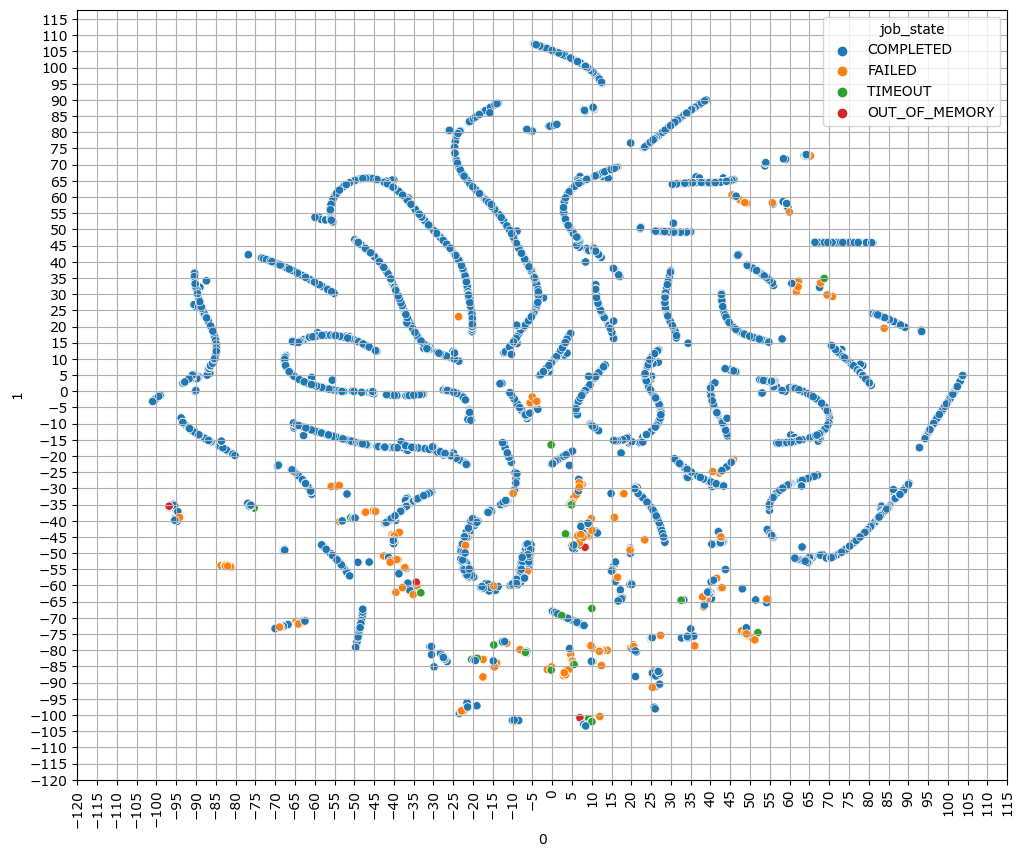

,0,1
0,-65.776222,5.194003
1,-56.772129,17.350710
2,-30.180258,-17.211430
3,46.441132,60.397247
4,-66.689232,6.430547
...,...,...
9995,69.679810,45.959087
9996,77.336189,45.942093
9997,80.742317,45.872013
9998,-76.146347,-35.168922


In [28]:
show_space(df_lda[0:10000], labels[0:10000], 2)

3D visualisation

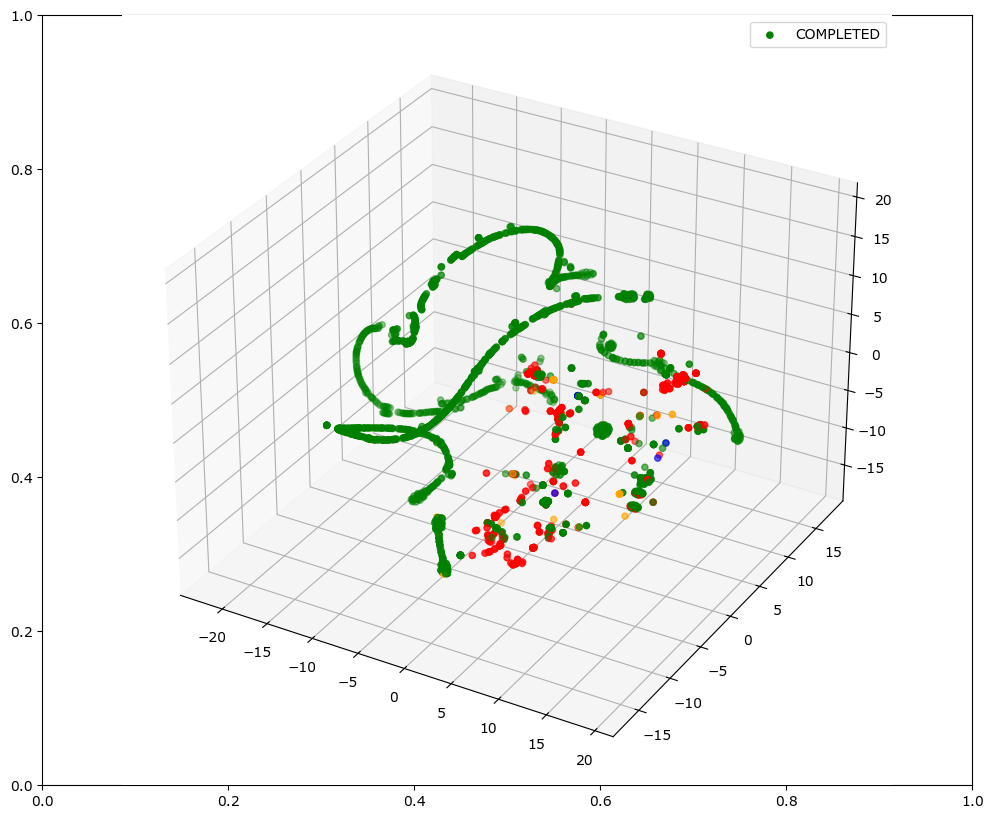

,0,1,2
0,-2.086663,5.549274,17.348179
1,-3.893857,9.212111,7.586713
2,-9.133196,8.095037,-5.774810
3,-0.353007,0.928313,3.344560
4,-1.851654,6.154349,16.600647
...,...,...,...
1995,16.274099,9.538431,-4.762311
1996,-8.878981,-6.820545,-1.466625
1997,0.809247,14.725900,-4.617657
1998,7.348420,-6.263401,5.861107


In [32]:
show_space(df_lda[0:2000], labels[0:2000], 3)

## LDA classification

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    df, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
val data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


In [10]:
lda = LinearDiscriminantAnalysis(n_components=3)
df_lda = lda.fit_transform(x_train, y_train)

### Classification with RF on LDA space

In [18]:
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

lda.transform(x_test)
y_pred = classifier.predict(x_test)

Accuracy : 0.9597779532457589


In [19]:
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")

Accuracy : 0.9597779532457589
F1 on test set: 0.7980021217940999
Recall on test set: 0.7775327753052027
Precision on test set: 0.8209512013497309


### Classification with LDA model

In [14]:
model = LinearDiscriminantAnalysis()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [17]:
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")

Accuracy : 0.8693629486824519
F1 on test set: 0.32055898356442464
Recall on test set: 0.30383317989886116
Precision on test set: 0.3753745177535708
